In [1]:
############################# NEW APPROACH
import random
import numpy
import math
# Keras
import keras
from keras.optimizers import SGD
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, AveragePooling2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
dat = pd.read_csv("C:/Users/Moritz/Desktop/Data/Data_path.csv")
dat.head()
dat.tail()

,labels,source,path
12157,female_disgust,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
12158,female_fear,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
12159,female_happy,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
12160,female_neutral,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
12161,female_sad,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...


In [3]:
fractions = np.array([0.6, 0.4])
# shuffle my input
dat = dat.sample(frac=1) 
# split into 3 parts
train, valtest = np.array_split(dat, (fractions[:-1].cumsum() * len(dat)).astype(int))

In [4]:
print(valtest)

                labels   source  \
3990      female_happy     TESS   
3870       female_fear     TESS   
3845       female_fear     TESS   
812       female_angry  RAVDESS   
6380        female_sad    CREMA   
...                ...      ...   
2254   female_surprise     TESS   
11829     male_disgust    CREMA   
6774      male_disgust    CREMA   
11110      female_fear    CREMA   
11226        male_fear    CREMA   

                                                    path  
3990   C:/Users/Moritz/Desktop/Data/TESS/YAF_happy/YA...  
3870   C:/Users/Moritz/Desktop/Data/TESS/YAF_fear/YAF...  
3845   C:/Users/Moritz/Desktop/Data/TESS/YAF_fear/YAF...  
812    C:/Users/Moritz/Desktop/Data/RAVDESS/Actor_06/...  
6380   C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...  
...                                                  ...  
2254   C:/Users/Moritz/Desktop/Data/TESS/OAF_Pleasant...  
11829  C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...  
6774   C:/Users/Moritz/Desktop/Data/CREMAD/Audio

In [5]:
len(valtest)

4865

In [6]:
'''
1. Data Augmentation method   
'''
def noise(data):
    """
    Adding White Noise.
    """
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(data**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,20/10)))
    noise=np.random.normal(0, RMS_n, data.shape[0])
    data = data+noise 
    return data

    
def pitch(data, sampling_rate = 44100):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sampling_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    

'''
2. Extracting the MFCC feature as an image (Matrix).  
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              )

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")

        # Augmentation? 
        if aug == 1 :
            data = noise(data)
        elif aug == 2 :
            data = pitch(data)
        elif aug == 3 :
            data = dyn_change(data)
        else :
            data = data
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        else:
            # Log-melspectogram
            melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
            logspec = librosa.amplitude_to_db(melspec)
            logspec = np.expand_dims(logspec, axis=-1)
            X[cnt,] = logspec
            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    '''Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    '''
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create 2D convolutional neural network'''
    nclass = 14
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (5,5), strides=(1, 1), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = AveragePooling2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(64, (5,5), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = AveragePooling2D()(x)
    x = Dropout(rate=0.3)(x)
    
    x = Convolution2D(64, (5,5), strides=(1, 1),  padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = AveragePooling2D()(x)
    x = Dropout(rate=0.4)(x)
    
    x = Convolution2D(64, (5,5), strides=(1, 1),  padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = AveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model



'''
# 5. Other functions 
'''
class get_results:
    '''
 
    '''
    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        '''predict on test set and get accuracy results'''
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        '''plot confusion matrix results'''
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):
        '''Print out the accuracy score and confusion matrix heat map of the Gender classification results'''
    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_anger':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happiness':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_anger':'male'
                   , 'male_fear':'male'
                   , 'male_happiness':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_anger':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happiness':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_anger':'male'
                   , 'male_fear':'male'
                   , 'male_happiness':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In [7]:
print(train)

              labels   source  \
3444    female_angry     TESS   
2791  female_disgust     TESS   
8268    male_disgust    CREMA   
8213  female_neutral    CREMA   
4115    female_happy     TESS   
...              ...      ...   
3233  female_neutral     TESS   
7849    male_neutral    CREMA   
5029    female_angry    CREMA   
1336      male_happy  RAVDESS   
9979       male_fear    CREMA   

                                                   path  
3444  C:/Users/Moritz/Desktop/Data/TESS/YAF_angry/YA...  
2791  C:/Users/Moritz/Desktop/Data/TESS/OAF_disgust/...  
8268  C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...  
8213  C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...  
4115  C:/Users/Moritz/Desktop/Data/TESS/YAF_happy/YA...  
...                                                 ...  
3233  C:/Users/Moritz/Desktop/Data/TESS/OAF_neutral/...  
7849  C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...  
5029  C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...  
1336  C:/Users/Moritz/D

In [8]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc2 = prepare_data(train, n = n_mfcc, aug = 1, mfcc = 1)

100%|██████████| 7297/7297 [03:53<00:00, 31.28it/s]


In [9]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc3 = prepare_data(train, n = n_mfcc, aug = 2, mfcc = 1)

100%|██████████| 7297/7297 [17:00<00:00,  7.15it/s]


In [10]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(train, n = n_mfcc, aug = 0, mfcc = 1)

100%|██████████| 7297/7297 [02:32<00:00, 47.98it/s]


In [11]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc4 = prepare_data(train, n = n_mfcc, aug = 3, mfcc = 1)

100%|██████████| 7297/7297 [02:31<00:00, 48.19it/s]


In [12]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc_test = prepare_data(valtest, n = n_mfcc, aug = 0, mfcc = 1)

100%|██████████| 4865/4865 [02:11<00:00, 37.01it/s]


In [13]:
print(mfcc_test.shape)

(4865, 30, 216, 1)


In [14]:
# model.evaluate: https://stackoverflow.com/questions/53971352/how-can-i-run-test-data-against-my-keras-trained-model

In [15]:
# Split between train and test 
X_1, X_non1, y_1, y_non1 = train_test_split(mfcc, train.labels, test_size=0.000000001, shuffle = True, random_state=42)

In [16]:
X_2, X_non2, y_2, y_non2 = train_test_split(mfcc2, train.labels, test_size=0.000000001, shuffle = True, random_state=42)

In [17]:
X_3, X_non3, y_3, y_non3 = train_test_split(mfcc3, train.labels, test_size=0.000000001, shuffle = True, random_state=42)

In [18]:
X_4, X_non4, y_4, y_non4 = train_test_split(mfcc4, train.labels, test_size=0.000000001, shuffle = True, random_state=42)

In [19]:
X_train = numpy.concatenate([X_1,X_2,X_3])
y_train = numpy.concatenate([y_1,y_2,y_3])

In [20]:

X_val, X_test, y_val, y_test = train_test_split(mfcc_test, valtest.labels, test_size=0.5, random_state = None, shuffle = False, stratify = None) 

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(21888, 30, 216, 1)
(21888,)
(2432, 30, 216, 1)
(2432,)


In [22]:
print(y_val)

3990       female_happy
3870        female_fear
3845        female_fear
812        female_angry
6380         female_sad
              ...      
6656         female_sad
11142      female_angry
2552       female_angry
10063      male_neutral
11934    female_neutral
Name: labels, Length: 2432, dtype: object


In [23]:
# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
y_val = np_utils.to_categorical(lb.fit_transform(y_val))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_val = (X_val - mean)/std

In [24]:
print(X_train.shape)
print(y_test.shape)

(21888, 30, 216, 1)
(2433, 14)


In [25]:
# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    batch_size=16, verbose = 2, epochs=62)

Epoch 1/62
1368/1368 - 203s - loss: 2.0065 - acc: 0.3119 - val_loss: 1.8426 - val_acc: 0.3310
Epoch 2/62
1368/1368 - 202s - loss: 1.5461 - acc: 0.4534 - val_loss: 1.2682 - val_acc: 0.5502
Epoch 3/62
1368/1368 - 202s - loss: 1.3932 - acc: 0.4992 - val_loss: 1.2908 - val_acc: 0.5337
Epoch 4/62
1368/1368 - 200s - loss: 1.3004 - acc: 0.5290 - val_loss: 1.0774 - val_acc: 0.5962
Epoch 5/62
1368/1368 - 200s - loss: 1.2439 - acc: 0.5493 - val_loss: 1.0623 - val_acc: 0.6151
Epoch 6/62
1368/1368 - 200s - loss: 1.1920 - acc: 0.5658 - val_loss: 1.0363 - val_acc: 0.6053
Epoch 7/62
1368/1368 - 200s - loss: 1.1444 - acc: 0.5836 - val_loss: 1.0083 - val_acc: 0.6365
Epoch 8/62
1368/1368 - 200s - loss: 1.1060 - acc: 0.6009 - val_loss: 0.9557 - val_acc: 0.6382
Epoch 9/62
1368/1368 - 199s - loss: 1.0868 - acc: 0.6060 - val_loss: 0.9979 - val_acc: 0.6197
Epoch 10/62
1368/1368 - 199s - loss: 1.0558 - acc: 0.6134 - val_loss: 0.9807 - val_acc: 0.6345
Epoch 11/62
1368/1368 - 198s - loss: 1.0445 - acc: 0.6203 -

In [26]:
model.evaluate(X_test, y_test, batch_size=16)

153/153 [==============================] - 4s 25ms/step - loss: 0.7841 - acc: 0.7115


[0.7841062545776367, 0.7114673256874084]

In [27]:
#15:04 - check model.summary() next to see how many parameters

In [28]:
valtest[1:10]

,labels,source,path
3870,female_fear,TESS,C:/Users/Moritz/Desktop/Data/TESS/YAF_fear/YAF...
3845,female_fear,TESS,C:/Users/Moritz/Desktop/Data/TESS/YAF_fear/YAF...
812,female_angry,RAVDESS,C:/Users/Moritz/Desktop/Data/RAVDESS/Actor_06/...
6380,female_sad,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
3213,female_neutral,TESS,C:/Users/Moritz/Desktop/Data/TESS/OAF_neutral/...
2781,female_disgust,TESS,C:/Users/Moritz/Desktop/Data/TESS/OAF_disgust/...
11122,female_neutral,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
4138,female_neutral,TESS,C:/Users/Moritz/Desktop/Data/TESS/YAF_neutral/...
3452,female_angry,TESS,C:/Users/Moritz/Desktop/Data/TESS/YAF_angry/YA...


In [29]:
valtest[2434:2444]

,labels,source,path
11706,male_fear,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
9673,female_angry,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
9272,female_happy,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
1861,female_neutral,RAVDESS,C:/Users/Moritz/Desktop/Data/RAVDESS/Actor_24/...
10222,male_sad,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
11034,female_sad,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
10854,female_happy,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
3816,female_fear,TESS,C:/Users/Moritz/Desktop/Data/TESS/YAF_fear/YAF...
1358,male_fear,RAVDESS,C:/Users/Moritz/Desktop/Data/RAVDESS/Actor_15/...
8678,female_disgust,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...


In [30]:
y_val[1:10]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [31]:
#5094, 7249

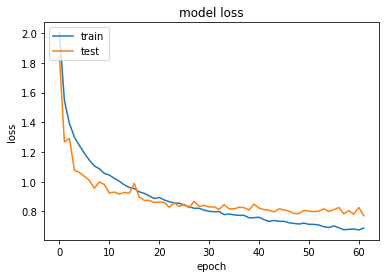

accuracy: 71.15%
153/153 - 4s


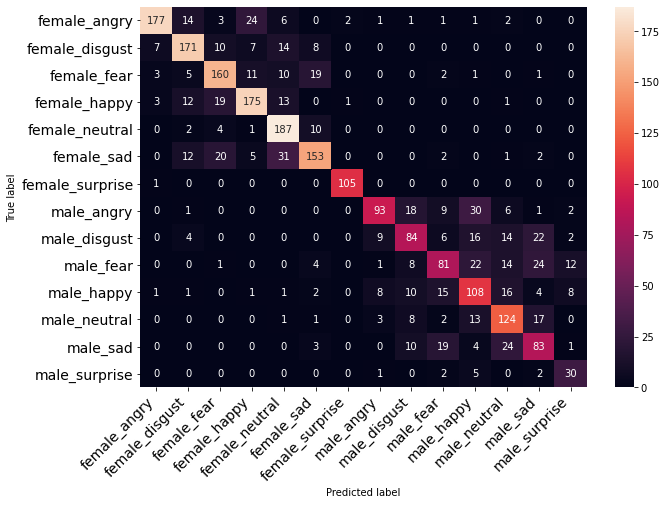

In [32]:
results = get_results(model_history,model,X_test,y_test, dat.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, dat.labels.unique(), model)

In [33]:
# Save model and weights
model_name = 'SER_trolol.h5'
save_dir = os.path.join(os.getcwd(), 'C:/Users/Moritz/Desktop/Data/')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:/Users/Moritz/Desktop/Data/SER_trolol.h5 


In [77]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("C:/Users/Moritz/Desktop/Data/SER_trolol.h5")
print("Loaded model from disk")
 


Loaded model from disk


In [78]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 216, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 216, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 216, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 30, 216, 32)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 108, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 108, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 108, 64)      

In [79]:
# Keras optimiser
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


accuracy: 71.15%


In [80]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds = preds.argmax(axis=1)
preds

153/153 [==============================] - 4s 25ms/step


array([10, 12, 10, ..., 12,  2,  9], dtype=int64)

In [81]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[0:10]

,actualvalues,predictedvalues
0,male_angry,male_happy
1,male_sad,male_sad
2,male_fear,male_happy
3,female_angry,female_angry
4,female_happy,female_happy
5,female_neutral,female_neutral
6,male_sad,male_sad
7,female_sad,male_sad
8,female_happy,female_disgust
9,female_fear,female_fear


In [39]:
valtest[2432:2442]

,labels,source,path
244,male_angry,SAVEE,C:/Users/Moritz/Desktop/Data/SAVEE/JK_a05.wav
984,male_sad,RAVDESS,C:/Users/Moritz/Desktop/Data/RAVDESS/Actor_09/...
11706,male_fear,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
9673,female_angry,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
9272,female_happy,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
1861,female_neutral,RAVDESS,C:/Users/Moritz/Desktop/Data/RAVDESS/Actor_24/...
10222,male_sad,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
11034,female_sad,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
10854,female_happy,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
3816,female_fear,TESS,C:/Users/Moritz/Desktop/Data/TESS/YAF_fear/YAF...


In [40]:
valtnew = valtest[-2433:]

In [41]:
valtnew = valtnew.reset_index()

In [42]:
valtnew

,index,labels,source,path
0,244,male_angry,SAVEE,C:/Users/Moritz/Desktop/Data/SAVEE/JK_a05.wav
1,984,male_sad,RAVDESS,C:/Users/Moritz/Desktop/Data/RAVDESS/Actor_09/...
2,11706,male_fear,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
3,9673,female_angry,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
4,9272,female_happy,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
...,...,...,...,...
2428,2254,female_surprise,TESS,C:/Users/Moritz/Desktop/Data/TESS/OAF_Pleasant...
2429,11829,male_disgust,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
2430,6774,male_disgust,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
2431,11110,female_fear,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...


In [43]:
del valtnew['index']

In [44]:
valtnew

,labels,source,path
0,male_angry,SAVEE,C:/Users/Moritz/Desktop/Data/SAVEE/JK_a05.wav
1,male_sad,RAVDESS,C:/Users/Moritz/Desktop/Data/RAVDESS/Actor_09/...
2,male_fear,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
3,female_angry,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
4,female_happy,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
...,...,...,...
2428,female_surprise,TESS,C:/Users/Moritz/Desktop/Data/TESS/OAF_Pleasant...
2429,male_disgust,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
2430,male_disgust,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...
2431,female_fear,CREMA,C:/Users/Moritz/Desktop/Data/CREMAD/AudioWAV/1...


In [45]:
finaldf

,actualvalues,predictedvalues
0,male_angry,male_happy
1,male_sad,male_sad
2,male_fear,male_happy
3,female_angry,female_angry
4,female_happy,female_happy
...,...,...
2428,female_surprise,female_surprise
2429,male_disgust,male_disgust
2430,male_disgust,male_sad
2431,female_fear,female_fear


In [94]:
finaldf['source']= valtnew['source']

In [95]:
finaldf

,actualvalues,predictedvalues,source
0,male_angry,male_happy,SAVEE
1,male_sad,male_sad,RAVDESS
2,male_fear,male_happy,CREMA
3,female_angry,female_angry,CREMA
4,female_happy,female_happy,CREMA
...,...,...,...
2428,female_surprise,female_surprise,TESS
2429,male_disgust,male_disgust,CREMA
2430,male_disgust,male_sad,CREMA
2431,female_fear,female_fear,CREMA


In [48]:
#######male part

In [49]:
fdf2 = finaldf[finaldf.predictedvalues == 'male_neutral']

In [96]:
rfdf2 = finaldf[finaldf.actualvalues == 'male_neutral']

In [50]:
fdf = fdf2[fdf2.predictedvalues != fdf2.actualvalues]

In [51]:
fdf2

,actualvalues,predictedvalues,source
14,male_happy,male_neutral,CREMA
21,male_neutral,male_neutral,CREMA
25,male_neutral,male_neutral,CREMA
42,male_neutral,male_neutral,CREMA
44,male_neutral,male_neutral,RAVDESS
...,...,...,...
2391,male_neutral,male_neutral,CREMA
2402,male_neutral,male_neutral,CREMA
2405,male_fear,male_neutral,CREMA
2411,male_neutral,male_neutral,SAVEE


In [52]:
fdf['source'].value_counts() # counts how many mispredicted "male_neutral" are in what data set

CREMA      66
SAVEE       7
RAVDESS     5
Name: source, dtype: int64

In [53]:
fdf1 = finaldf[finaldf.predictedvalues != finaldf.actualvalues]

In [54]:
fdf1['source'].value_counts() # counts how many mispredicted totals are in what data set

CREMA      584
RAVDESS     71
SAVEE       47
Name: source, dtype: int64

In [55]:
finaldf['source'].value_counts() # counts how many total values we have in what data set

CREMA      1499
TESS        548
RAVDESS     279
SAVEE       107
Name: source, dtype: int64

In [56]:
fdf2['source'].value_counts() # counts how many total predicted 'male neutral' we have

CREMA      138
SAVEE       34
RAVDESS     30
Name: source, dtype: int64

In [97]:
rfdf2['source'].value_counts()

CREMA      109
SAVEE       32
RAVDESS     28
Name: source, dtype: int64

In [57]:
#female part

In [58]:
ffdf2 = finaldf[finaldf.predictedvalues == 'female_neutral']
ffdf = ffdf2[ffdf2.predictedvalues != ffdf2.actualvalues]

In [59]:
ffdf['source'].value_counts() # counts how many mispredicted "female_neutral" are in what data set

CREMA      64
RAVDESS    12
Name: source, dtype: int64

In [60]:
ffdf2['source'].value_counts() # counts how many total predicted 'female neutral' we have

CREMA      149
TESS        70
RAVDESS     44
Name: source, dtype: int64

In [82]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldff = actual.join(preds)
finaldff[0:10]

ValueError: invalid literal for int() with base 10: 'male_happy'

In [83]:
# Write out the predictions to disk
finaldf.to_csv('C:/Users/Moritz/Desktop/Data/Predictionslol.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,192
female_disgust,222
female_fear,217
female_happy,224
female_neutral,263
female_sad,200
female_surprise,108
male_angry,116
male_disgust,139


In [84]:
# Get the predictions file 
finaldf = pd.read_csv("C:/Users/Moritz/Desktop/Data/Predictionslol.csv")
classes = finaldf.actualvalues.unique()
classes.sort() 

0.7114673242909988


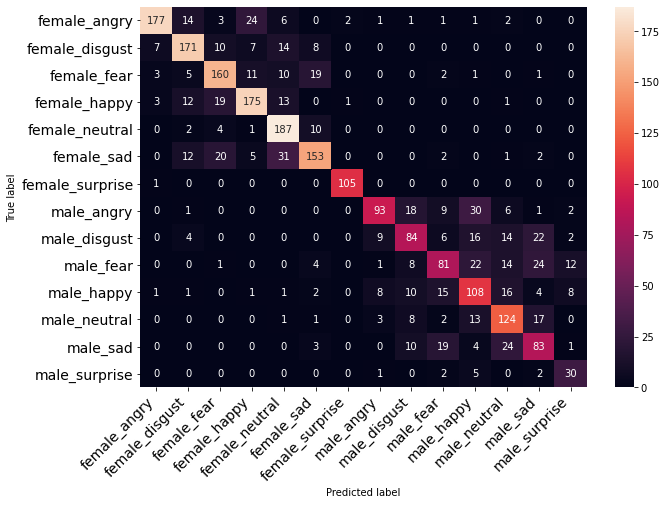

In [85]:
# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [86]:
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [87]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.92      0.76      0.83       232
 female_disgust       0.77      0.79      0.78       217
    female_fear       0.74      0.75      0.75       212
   female_happy       0.78      0.78      0.78       224
 female_neutral       0.71      0.92      0.80       204
     female_sad       0.77      0.68      0.72       226
female_surprise       0.97      0.99      0.98       106
     male_angry       0.80      0.58      0.67       160
   male_disgust       0.60      0.54      0.57       157
      male_fear       0.58      0.49      0.53       167
     male_happy       0.54      0.62      0.58       175
   male_neutral       0.61      0.73      0.67       169
       male_sad       0.53      0.58      0.55       144
  male_surprise       0.55      0.75      0.63        40

       accuracy                           0.71      2433
      macro avg       0.71      0.71      0.70      2433
   weighted avg       0.72   

0.717632552404439


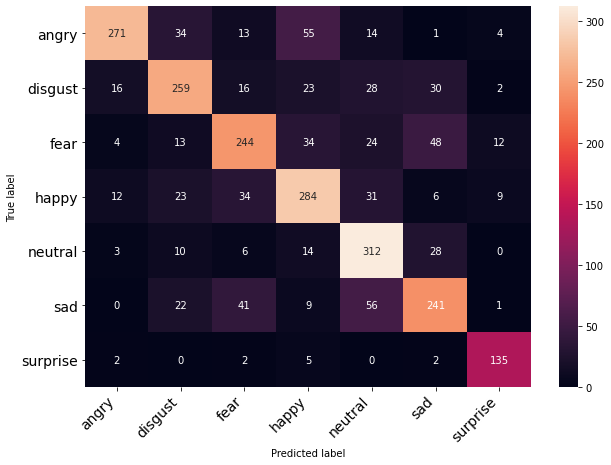

In [99]:
modidf = pd.read_csv("C:/Users/Moritz/Desktop/Data/Predictionslol.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [100]:
c.diagonal()/c.sum(axis=1)

array([0.69132653, 0.69251337, 0.64379947, 0.71177945, 0.83646113,
       0.65135135, 0.92465753])

153/153 - 4s
0.8479243732018085


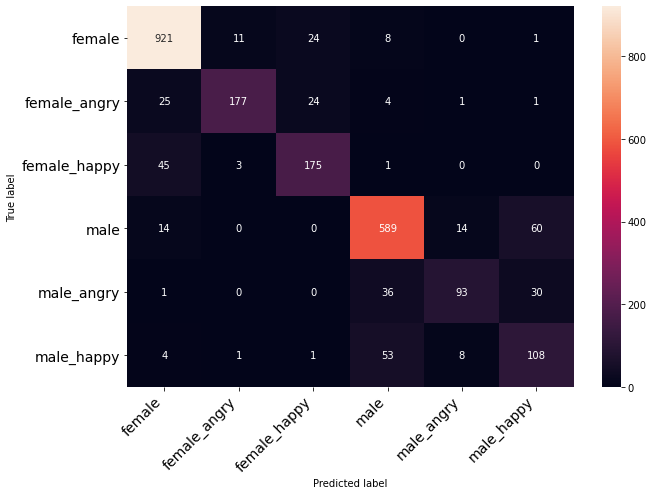

In [101]:
results.accuracy_results_gender(X_test, y_test, dat.labels.unique(), model)